In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Choose the "true" parameters.
m_true = -2
b_true = 5
f_true =0.3

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
#yerr = 0.1+0.5*np.random.rand(N)
yerr = 0.01+0.75*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [2]:
###I added for comparison

xtrue=np.arange(0,10,1/N)

ytrue=m_true*xtrue+b_true

###Least squares method, not used here 
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

In [3]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [4]:
lnlike([m_true,b_true,np.log(f_true)],x,y,yerr)

-36.26614383006899

In [5]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [21]:
print(result)

      fun: 35.375330245861214
 hess_inv: array([[ 0.00899797, -0.02397111,  0.00472075],
       [-0.02397111,  0.07105088, -0.01197034],
       [ 0.00472075, -0.01197034,  0.01716768]])
      jac: array([ 0.00000000e+00,  4.76837158e-07, -9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([-2.04486238,  5.21947013, -1.28012336])


In [6]:
###I added another line for comparison
print(result)
xnew=np.arange(0,10,1/N)

ynew=m_ml*xnew+b_ml

      fun: 35.375330245861214
 hess_inv: array([[ 0.00899797, -0.02397111,  0.00472075],
       [-0.02397111,  0.07105088, -0.01197034],
       [ 0.00472075, -0.01197034,  0.01716768]])
      jac: array([ 0.00000000e+00,  4.76837158e-07, -9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([-2.04486238,  5.21947013, -1.28012336])


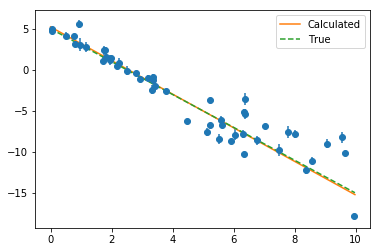

In [7]:
plt.errorbar(x,y,yerr,fmt='o')
plt.plot(xnew,ynew,label='Calculated')
plt.plot(xtrue,ytrue,'--',label='True')
plt.legend(loc='best')
plt.show()

In [8]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [9]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [10]:
ndim, nwalkers = 3, 50
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [11]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [12]:
sampler.run_mcmc(pos, 500)

(array([[-1.99137944,  5.12485473, -1.41945656],
        [-2.26368362,  5.98207204, -1.36928485],
        [-1.99287348,  5.04171181, -1.18904384],
        [-2.12108283,  5.49836575, -1.01340998],
        [-2.01439928,  4.95552544, -1.19680995],
        [-2.13039056,  5.47260485, -1.36785149],
        [-2.01772552,  5.19695785, -1.261423  ],
        [-1.9546769 ,  4.95278677, -1.14825759],
        [-1.99373207,  5.043865  , -1.35269361],
        [-2.02108622,  5.20239077, -1.18641933],
        [-2.05527104,  5.14897953, -1.19342651],
        [-2.06840566,  5.25116985, -1.43433608],
        [-2.25109063,  5.74184151, -1.15209097],
        [-1.9257108 ,  4.95566348, -0.92696551],
        [-2.07265702,  5.2566351 , -1.16270961],
        [-2.03618096,  5.21119459, -1.28702134],
        [-2.00061635,  5.11120272, -1.26280912],
        [-2.15246107,  5.40562193, -1.21724094],
        [-2.14600464,  5.44029755, -1.2664633 ],
        [-2.05399385,  5.37591046, -1.05550048],
        [-1.95938823

In [13]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

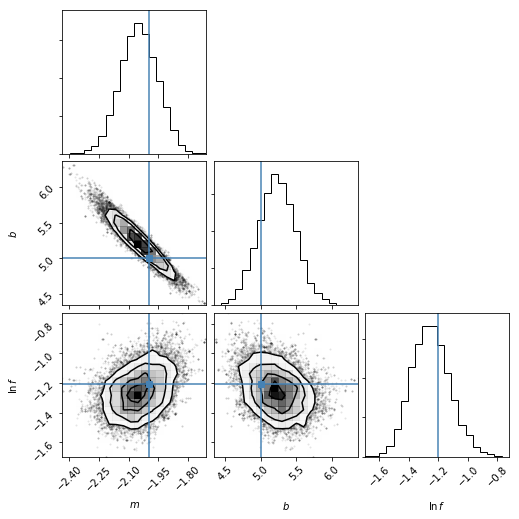

In [14]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("triangle.png")

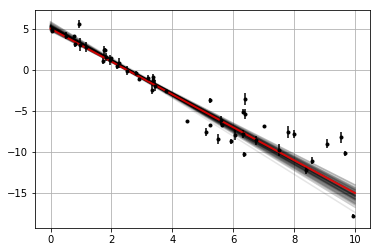

In [15]:
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.grid()
plt.show()

In [16]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

###should be between 0.25-0.5###

Mean acceptance fraction: 0.658


In [17]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))